# SmolLM Super Weight

In [2]:
from typing import Sequence
import torch
from tqdm import tqdm

### Load model

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-1.7B"
device = "cpu" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
# inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
# outputs = model.generate(inputs)
# print(tokenizer.decode(outputs[0]))

/home/anatoly/Projects/SmolLMSuperWeight/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model.model.layers

ModuleList(
  (0-23): 24 x LlamaDecoderLayer(
    (self_attn): LlamaAttention(
      (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
  )
)

In [5]:
num_layers = len(model.model.layers)
num_layers

24

## Super weight identification

 The method for identifying super weights is based on the finding that super weights create super activations. Super activations are exceptionally massive activations observed in LLMs that persist across many layers, have constant magnitude, and always exist at the same position regardless of input. The activation's channel aligns with the super weight's channel, and the super activation first appears right after the super weight. Pruning the super weight drastically reduces the magnitude of this massive activation, suggesting a causal link.

Super weights can be located by detecting the spikes in the inputs and outputs distributions of the `mlp.down_proj` module across different layers. This detection process is efficient and requires only a single input prompt, not a full validation dataset. First, we need to save input and output activations for each layer:

In [6]:
model.get_submodule(f"model.layers.2.mlp.down_proj")

Linear(in_features=8192, out_features=2048, bias=False)

In [7]:
#lists to store inputs and outputs activations
all_inputs = []
all_outputs = []

# Register the hook for each layer
for i in range(num_layers):
    def save_activations_hook(module, inputs, outputs):
        if isinstance(inputs, Sequence):
            inputs = inputs[0]
        all_inputs.append(inputs.cpu())
        all_outputs.append(outputs.cpu())
    layer = model.get_submodule(f"model.layers.{i}.mlp.down_proj")
    layer.register_forward_hook(save_activations_hook)

In [8]:
with torch.no_grad():
    inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
    outputs = model(inputs[:, :1])

In [9]:
len(all_inputs), len(all_outputs)

(24, 24)

Plot the extreme outliers in the input and output activations of the mlp.down_proj module for all transformer layers

In [10]:
max_input_activations = [inp_act.abs().max().item() for inp_act in all_inputs]
max_output_activations = [out_act.abs().max().item() for out_act in all_outputs]

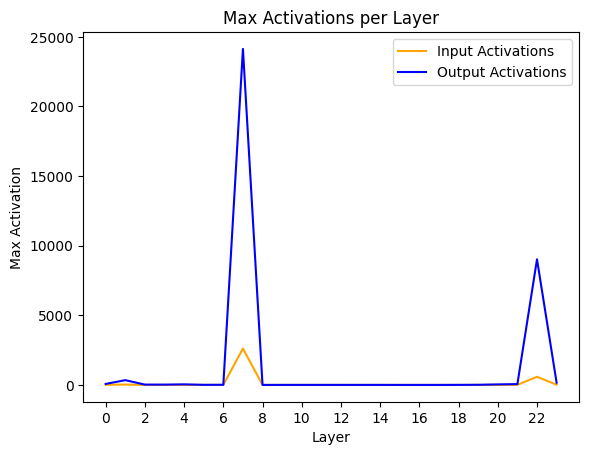

In [11]:
import matplotlib.pyplot as plt

plt.plot(max_input_activations, label="Input Activations", color="orange")
plt.plot(max_output_activations, label="Output Activations", color="blue")
plt.xlabel("Layer")
plt.ylabel("Max Activation")
plt.title("Max Activations per Layer")
plt.xticks(range(0, num_layers, 2))
plt.legend()
plt.show()

We can see that super activations first appear after layer 1 output So, the super weight must be in layer 1. Lets find it!

Specifically, for a given layer, the channel index of the large maximum-magnitude activation in the down_proj input indicates the row of the super weight.
The channel index of the large maximum-magnitude activation in the down_proj output in the same layer indicates the column of the super weight.

In [12]:
all_outputs[1].abs().max(dim=-1)

torch.return_types.max(
values=tensor([[342.2403]]),
indices=tensor([[749]]))

In [13]:
all_inputs[1].abs().max(dim=-1)

torch.return_types.max(
values=tensor([[26.4583]]),
indices=tensor([[4987]]))

So the super weight is [749, 4987] of mlp down_proj from layer 1. Lets check that it actually is a super weight by looking at the activations it produces in each layer.

In [14]:
super_activations = [abs(act[0, -1, 749]) for act in all_outputs]


/tmp/ipykernel_89677/3639201231.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


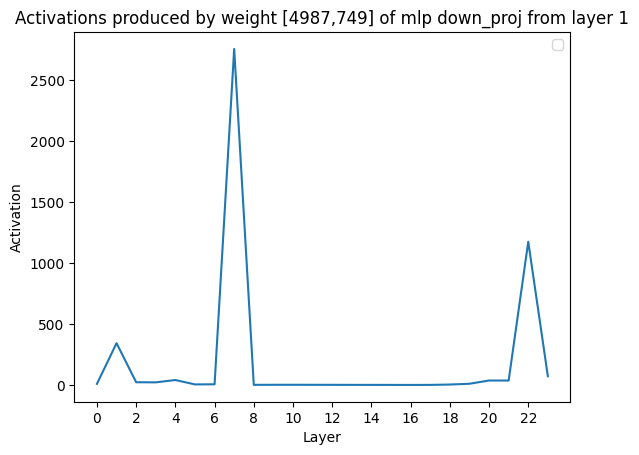

In [15]:
plt.plot(super_activations)
plt.xlabel("Layer")
plt.ylabel("Activation")
plt.title("Activations produced by weight [4987,749] of mlp down_proj from layer 1")
plt.xticks(range(0, num_layers, 2))
plt.legend()
plt.show()

We can see from that output activations produced by the weight [749, 4987] of mlp down_proj from layer 1 are match to maximum output activations from plot above.

## Calculate perplexity on Wiki-2

In [ ]:
inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
outputs = model.generate(inputs)
print(f"Initial output: {tokenizer.decode(outputs[0])}")
super_wight_value = model.model.layers[1].mlp.down_proj.weight[749, 4987].item()
with torch.no_grad():
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
    inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
    outputs = model.generate(inputs)
    print(f"Output with weight [4987,749] set to 0: {tokenizer.decode(outputs[0])}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_wight_value

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Transformer architecture is a type of neural network that is used for unsupervised learning. It is a type of neural network that


In [17]:
from datasets import load_dataset

test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")[:10]
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

In [18]:
max_length = model.config.max_position_embeddings
# stride = max_length // 2
stride = 300
seq_len = encodings.input_ids.size(1)
max_length, stride, seq_len



(8192, 300, 482)

In [ ]:
from tqdm import tqdm

def calculate_perplexity(model, encodings):
    nll_sum = 0.0
    n_tokens = 0
    prev_end_loc = 0

    # calculations are based on https://huggingface.co/docs/transformers/en/perplexity#example-calculating-perplexity-with-gpt-2-in--transformers
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
    
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)

            neg_log_likelihood = outputs.loss # loss is calculated using CrossEntropyLoss which averages over valid labels
    
        # Accumulate the total negative log-likelihood and the total number of tokens
        num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
        batch_size = target_ids.size(0)
        num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
        nll_sum += neg_log_likelihood * num_loss_tokens
        n_tokens += num_loss_tokens

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
    ppl = torch.exp(avg_nll)
    return ppl.item()

In [ ]:
with torch.no_grad():
    ppl=calculate_perplexity(model, encodings)
    print(f"Initial perplexity: {ppl}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
    ppl = calculate_perplexity(model, encodings)
    print(f"Perplexity with weight [4987,749] set to 0: {ppl}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_wight_value

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:27<?, ?it/s]

Perplexity: 8.732063293457031


## Instruct model evaluation

In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-1.7B-Instruct"

device = "cpu" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# for multiple GPUs install accelerate and do `model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto")`
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

In [4]:
messages = [{"role": "user", "content": "What is the capital of France."}]
input_text=tokenizer.apply_chat_template(messages, tokenize=False)
inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
outputs = model.generate(inputs, max_new_tokens=50, temperature=0.2, top_p=0.9, do_sample=True)
print(tokenizer.decode(outputs[0]))

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|im_start|>system
You are a helpful AI assistant named SmolLM, trained by Hugging Face<|im_end|>
<|im_start|>user
What is the capital of France.<|im_end|>
<|im_start|>assistant
The capital of France is Paris.<|im_end|>


### MMLU-Prod dataset

In [5]:
from datasets import load_dataset

dataset = load_dataset('TIGER-Lab/MMLU-Pro')
categories = ['computer science', 'math', 'chemistry', 'engineering', 'law', 'biology',
                  'health', 'physics', 'business', 'philosophy', 'economics', 'other',
                  'psychology', 'history']

In [6]:
def form_options(options: list):
    option_str = 'Options are:\n'
    opts = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
    for opt, o in zip(options, opts):
        option_str += f'({o}): {opt}' + '\n'
    return option_str

In [7]:
import re
import random

def get_prediction(output):
    pattern = r"answer is \(?([ABCDEFGHIJ])\)?"
    match = re.search(pattern, output)
    if match:
        return match.group(1)
    else:
        print("extraction failed, do a random guess")
        return random.choice(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])

In [8]:
def run_one_question(question: str):
    messages = [{"role": "system",
                "content": "You are an knowledge expert, you are supposed to answer the multi-choice question to derive your final answer as `The answer is ...`."},
            {"role": "user", "content": question}]
    with torch.no_grad():
        input_text=tokenizer.apply_chat_template(messages, tokenize=False)
        inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
        # generation params are taken from https://huggingface.co/datasets/TIGER-Lab/MMLU-Pro/blob/main/run_gpt4o.py
        outputs = model.generate(inputs, max_new_tokens=50, temperature=0.1, top_p=1, do_sample=True)
    return tokenizer.decode(outputs[0])

In [9]:
prompts = {c: '' for c in categories}
for d in dataset['validation']:
        prompts[d['category']] += 'Q:' + ' ' + d['question'] + '\n' + form_options(d['options']) + '\n' + d['cot_content'] + '\n\n'

In [10]:
def calc_mmlu_pro_acc():
    success, fail = 0, 0
    for i in tqdm(range(30)):
        entry = dataset["test"][i]
        # print(entry)
        prefix = prompts[entry['category']]
        query = prefix + 'Q: ' + entry['question'] + '\n' + form_options(entry['options']) + '\n'
        #query = 'Q: ' + entry['question'] + '\n' + form_options(entry['options']) + '\n'
        answer = run_one_question(query)
        #print(answer)
        entry['solution'] = answer
        prediction = get_prediction(answer)
        if entry["answer"] == prediction:
            success += 1
        else:
            fail += 1

    return success / (success + fail)

In [13]:
super_wight_value = model.model.layers[1].mlp.down_proj.weight[749, 4987].item()

In [ ]:
super_wight_value = model.model.layers[1].mlp.down_proj.weight[749, 4987].item()
with torch.no_grad():
    print(f"Initial accuracy: {calc_mmlu_pro_acc()}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
    print(f"Accuracy with weight [749,4987] set to 0: {calc_mmlu_pro_acc()}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_wight_value

100%|██████████| 30/30 [24:25<00:00, 48.86s/it]


Initial accuracy: 0.16666666666666666


100%|██████████| 30/30 [24:15<00:00, 48.53s/it]


Accuracy with weight [4987,749] set to 0: 0.16666666666666666


NameError: name 'super_wight_value' is not defined

### Hellaswag dataset

In [14]:
from datasets import load_dataset

dataset = load_dataset("hellaswag", split="validation")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/24.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/6.11M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/6.32M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/39905 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10042 [00:00<?, ? examples/s]

In [15]:
# code from https://github.com/pchizhov/hellaswag-evaluation/blob/main/evaluation_scripts/evaluate_generation.py
import torch
import json
import re
import datasets
import random


def preprocess(text):
    text = text.strip()
    # NOTE: Brackets are artifacts of the WikiHow dataset portion of HellaSwag.
    text = text.replace(" [title]", ". ")
    text = re.sub("\[.*?\]", "", text)
    text = text.replace("  ", " ")
    return text


def process_docs(dataset: datasets.Dataset, eval_type='full') -> datasets.Dataset:
    def _process_doc(doc):
        if eval_type == 'full':
            ctx = doc["ctx_a"] + " " + doc["ctx_b"].capitalize()
        else:
            ctx = doc["ctx_b"].capitalize()
        choices = [preprocess(ending) for ending in doc["endings"]]
        gold_index = int(doc["label"])

        indices = list(range(len(choices)))
        random.shuffle(indices)
        shuffled_choices = [choices[i] for i in indices]
        new_gold_index = indices.index(gold_index)

        if eval_type == 'full':
            query = preprocess(doc["activity_label"] + ": " + ctx)
        else:
            query = preprocess(ctx)

        out_doc = {
            "query": query,
            "choices": shuffled_choices,
            "gold": new_gold_index,
        }
        return out_doc

    return dataset.map(_process_doc)


def construct_prompt(context, endings):
    prompt = (
        "You are given a situation followed by four possible endings. "
        "Choose the most appropriate ending by selecting the corresponding number. "
        "Respond only with the number of the correct answer.\n\n"
        f"Context: {context}\n"
    )
    for i, ending in enumerate(endings):
        prompt += f"{i + 1}. {ending}\n"
    prompt += "\nAnswer: "
    return prompt


def generate_answer(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=inputs.input_ids.shape[1] + 2)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    return answer.split("Answer:")[-1].strip()


def compute_real_accuracy(filename):
    with open(filename, "r") as f:
        data = json.load(f)

    correct = 0
    for question in data:
        digits = [a for a in question['generated_answer'] if a in '1234']
        if len(digits) == 0:
            print('ERROR:', question)
        else:
            correct += int(digits[0] == question['correct_answer'])

    return correct / len(data)

<>:13: SyntaxWarning: invalid escape sequence '\['
<>:13: SyntaxWarning: invalid escape sequence '\['
/tmp/ipykernel_211378/3337459041.py:13: SyntaxWarning: invalid escape sequence '\['
  text = re.sub("\[.*?\]", "", text)


In [18]:
dataset = process_docs(dataset)



def evaluate():
    correct = 0
    total = len(dataset)
    results = []
    for i in tqdm(range(30)):
        example = dataset[i]
        context = example["query"]
        endings = example["choices"]
        correct_answer = str(example["gold"] + 1)  # Labels are 0-indexed
        prompt = construct_prompt(context, endings)
        generated_answer = generate_answer(prompt)

        results.append({
            "context": context,
            "options": endings,
            "correct_answer": correct_answer,
            "generated_answer": generated_answer
        })

        if correct_answer == generated_answer:
            correct += 1

    accuracy = correct / total
    print(f"Initial Accuracy: {accuracy:.2%}")

    filename = f"data/hellaswag_SmalLM2.json"

    with open(filename, "w") as f:
        json.dump(results, f, indent=4)


    real_accuracy = compute_real_accuracy(filename)
    print(f"Real Accuracy: {real_accuracy:.2%}")
    return accuracy

Map:   0%|          | 0/10042 [00:00<?, ? examples/s]

In [ ]:
with torch.no_grad():
    print(f"Initial accuracy: {evaluate()}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
    print(f"Accuracy with weight [4987,749] set to 0: {evaluate()}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_wight_value


 10%|█         | 3/30 [00:13<02:10,  4.84s/it]